Given the equations 
$$
a \cdot \nabla \phi -  \kappa \Delta \phi = 0\\
\phi(0) = 0\\
\phi(1) = 1\\
\kappa = 1\\
a = 1 \ and\  10\\
L = 1
$$

find approximate solutions of $\phi(x)$ for each of the following (combining each option, and convective velocities):
- central difference for the diffusion term
- central and up-wind for the convective term
- uniform discretization with 3 and 5 nodes

and compare to the exact solution given by 
$$
\phi(x) = \frac{e^{Pe\frac{x}{L}}-1}{e^{Pe}-1}\\
Pe = \frac{a \cdot L}{\kappa}\\
$$

Plot a total of 8 graphs for different convective velocities, convection schemes, and discretization, comparing with the exact solution. For each plot, describe the accuracy and behaviour of solution. 

The operator $ a \cdot \nabla$ is equivalent to $a \partial / \partial x$ for this problem, and $\Delta = \nabla ^2 = \partial^2 / \partial x^2$. According to the calculations done in the course, the formulations for these operators is
- Central difference 2nd order:
$$
\partial^2 u/ \partial x^2 = \frac{u_{i-1}-2u_i + u_{i+1}}{\Delta x^2} + O(\Delta x^2)
$$
- Central difference 1st order:
$$
\partial u/ \partial x = \frac{u_{i+1} - u_{i-1}}{2\Delta x} + O(\Delta x^2)
$$
- Forward difference 1st order:
$$
\partial u/ \partial x = \frac{u_{i+1} - u_{i}}{\Delta x} + O(\Delta x)
$$

so ignoring the error as that is not a calculated term, but a representation of the total error of this approximation, the equation we want to solve is either 
- (1)
$$
a \cdot \frac{\phi_{i+1} - \phi_{i-1}}{2\Delta x} - \kappa \frac{\phi_{i-1}-2\phi_i + \phi_{i+1}}{\Delta x^2} = 0\\
\implies \phi_i = \frac{\phi_{i+1} + \phi_{i-1}}{2} + \frac{\Delta x}{2\kappa} \left( a \cdot \frac{\phi_{i+1} - \phi_{i-1}}{2} \right)
$$

and 
- (2)
$$
a \cdot \frac{\phi_{i+1} - \phi_{i}}{\Delta x} - \kappa \frac{\phi_{i-1}-2\phi_i + \phi_{i+1}}{\Delta x^2} = 0\\
\implies \phi_i  = -\frac{\frac{a}{\Delta x}\phi_{i+1} + \frac{\kappa}{\Delta x^2} ( \phi_{i-1} + \phi_{i+1} )}{\left( \frac{a}{\Delta x} - \frac{2\kappa}{\Delta x^2}\right)}
$$


In [118]:
## Imports
import numpy as np
import matplotlib.pyplot as plt

In [137]:
## Given Variables
a = [1,10]
k = 1
L = 1
phi_0 = 0
phi_1 = 1
n_nodes_exact = 100
n_iter = 100

In [138]:
## define exact solution equations
def phi_exact(x,  Pe, L):
    "calculates the exact value of the solution"
    phi = (np.exp(Pe*(x/L))-1)/(np.exp(Pe)-1)
    return phi
                    
def Peclet(a, L, k):
    "calculates peclet number"
    Pe = a*L/k
    return Pe         

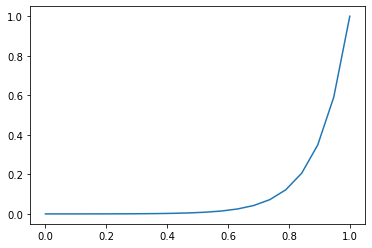

In [117]:
## plot exact equations
x_exact = np.linspace(0,1,20)
Pe = Peclet(a[1], L, k)
phi_exct = phi_exact(x_exact, Pe, L)
plt.plot(x_exact, phi_exct)

First Approach
In this approach, from the formulations we made, we can create an iterative approach. However we need to first address the issue that the first pass will encounter values that are not yet valid. The way I will handle that is by selectively ignoring the terms that are not yet valid. This is a naive approach and we could speed the process up by taking different first guesses, such as interpolating between the boundaries,but that would be less general. The way this is set up, no assumption is made about the boundary conditions other then that they exist. In these equations, this is equivalent to setting those values to zero.

In [139]:
## Setting up a "mesh"
def create_mesh(boundary_values, boundary_locations, n_nodes, dimensions):
    """
    takes 1d mesh conditions and returns a vector that only has values
    where boundary conditions were specified. Row 0 is the coordinates
    and Row 1 is the array values
    """
    #create array of invalid values
    mesh_values = np.full((n_nodes), np.nan)
    
    #create array with correct coordinates
    mesh_coordinates = np.linspace(*dimensions, n_nodes)
    
    #stack the two arrays
    mesh = np.stack([mesh_coordinates, mesh_values])
    
    #find the array index to apply the boundary condition to
    boundary_indices = np.in1d(mesh[0, :], boundary_locations)
    
    #update the values array with the boundary conditions
    mesh[1, boundary_indices] = boundary_values
    
    return mesh, boundary_indices

mesh, indices = create_mesh(boundary_values = [0,1], boundary_locations = [0,1], n_nodes = 3, dimensions = [0,1])
print(mesh, indices)

[[0.  0.5 1. ]
 [0.  nan 1. ]] [ True False  True]


$$
a \cdot \frac{\phi_{i+1} - \phi_{i-1}}{2\Delta x} - \kappa \frac{\phi_{i-1}-2\phi_i + \phi_{i+1}}{\Delta x^2} = 0\\
\implies \phi_i = \frac{\phi_{i+1} + \phi_{i-1}}{2} + \frac{\Delta x}{2\kappa} \left( a \cdot \frac{\phi_{i+1} - \phi_{i-1}}{2} \right)
$$

In [140]:
## Setting up the basic finite difference functions
def phi_CD_only(mesh_values, i, dx, k=1, a=1):
    """
    takes a mesh array and a current index
    and applies the equation at the current location based on current values
    using the central difference method for both the convection and diffusion
    """
    
    ##handle invalid values
    phi = mesh_values[i-1:i+2]
    phi[np.isnan(phi)]=0
    #print(phi)
    
    term_1 = phi[0]*(a*dx + 2*k)
    term_2 = phi[2]*(2*k-a*dx)
    phi[1] = (term_1 + term_2)/(4*k)
    return None

def phi_CD_and_FD(mesh_values, i, dx, k=1, a=1):
    """
    takes a mesh array and a current index
    and applies the equation at the current location based on current values
    using the central difference method for both the convection and diffusion
    """
    ##calculate the terms
    ##handle invalid values

    phi = mesh_values[i-1:i+2]
    phi[np.isnan(phi)]=0
    #print(phi)
    
    term_1 = phi[0]*(k)
    term_2 = phi[2]*(k-a*dx)
    phi[1] = (term_1 + term_2)/(2*k-a*dx)
    return None

def find_dx(mesh_coordinates, i):
    """
    takes a mesh array and a current index
    and finds the average delta x around that index. 
    It finds the exact dx for a uniform node distribution
    but also handles the case where there are small 
    variations around a node of a uniform mesh
    """
    ##get differential of coordinates around node
    dx_array = np.diff(mesh_coordinates[i-1:i+2])
    
    ##get average delta
    dx = dx_array.mean()
    
    return dx
    
def array_iteration(fun, mesh, fixed_index, kappa, a):
    """
    takes a function and a mesh, and iterates through the mesh
    values with the function
    """
    
    for i, coordinate in enumerate(mesh[0]):
        ## if the location isn't a boundary condition
        if not(fixed_index[i]):
            #print(i)
            dx = find_dx(mesh[0], i)
            fun(mesh[1], i, dx, kappa, a)
            


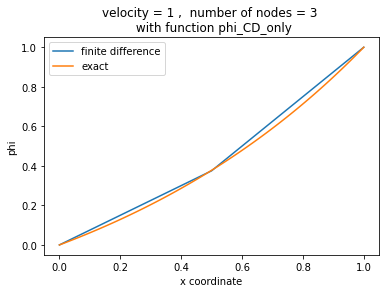

error


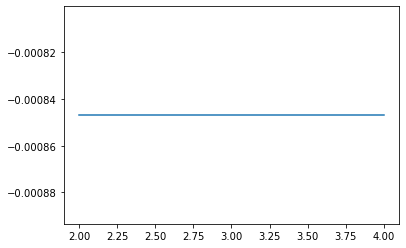

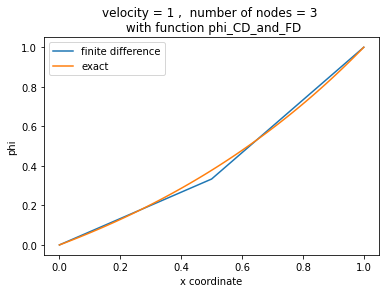

error


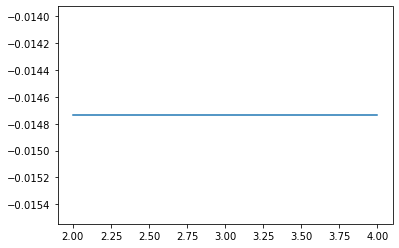

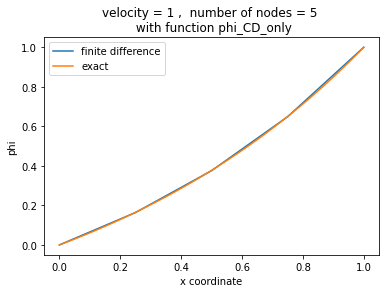

error


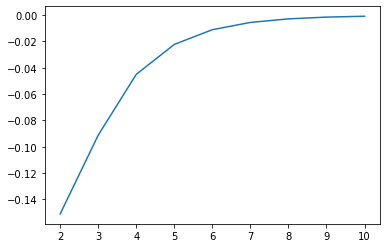

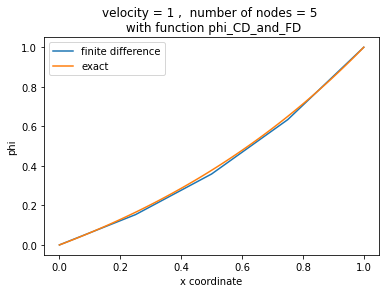

error


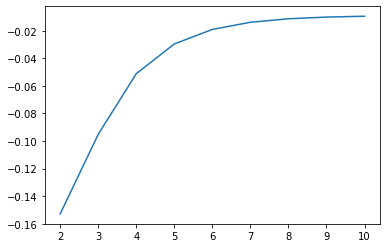

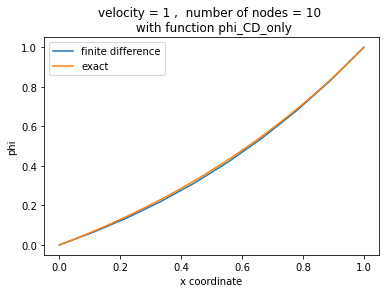

error


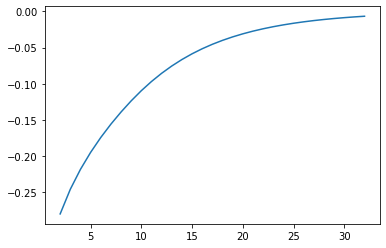

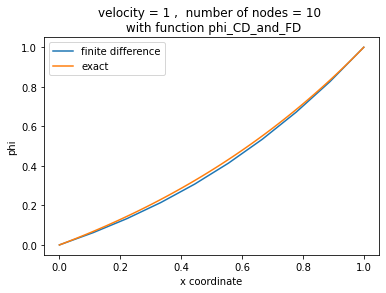

error


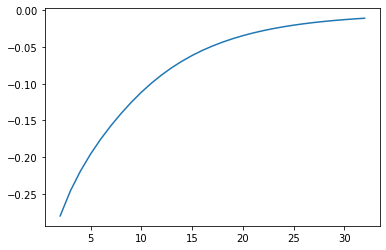

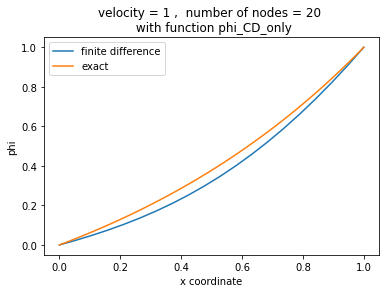

error


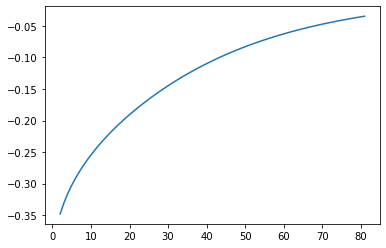

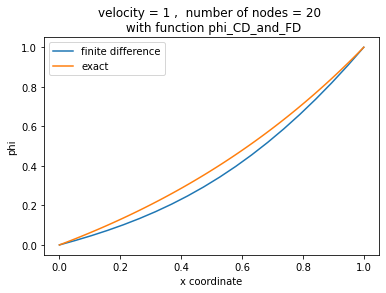

error


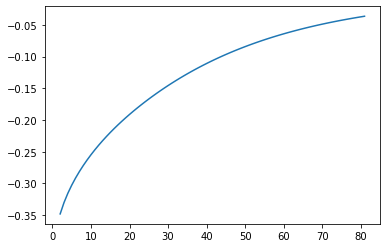

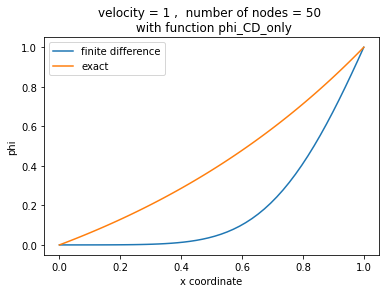

error


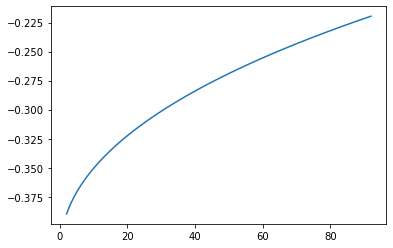

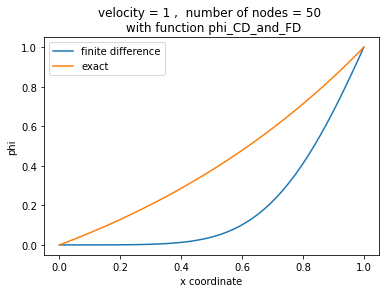

error


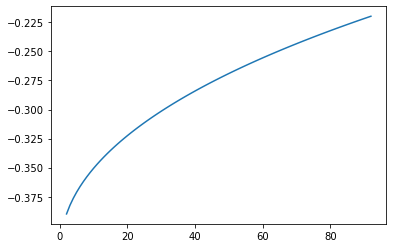

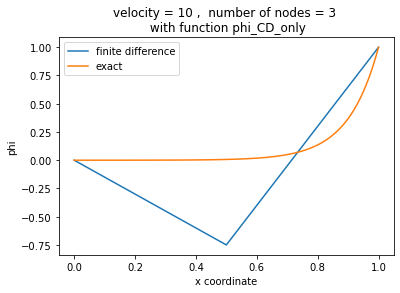

error


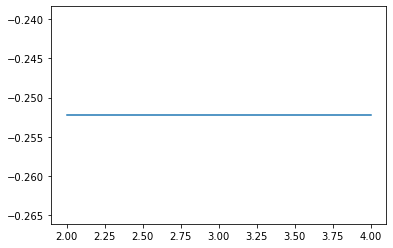

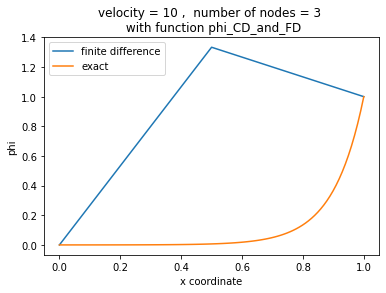

error


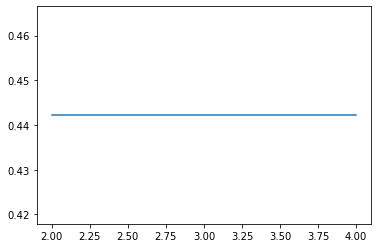

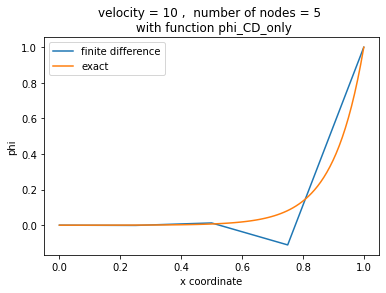

error


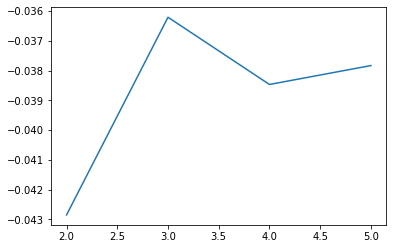

<ipython-input-140-bf3ee9abb8c6>:34: RuntimeWarning: overflow encountered in double_scalars
  phi[1] = (term_1 + term_2)/(2*k-a*dx)
C:\Users\walth\anaconda3\lib\site-packages\numpy\core\_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


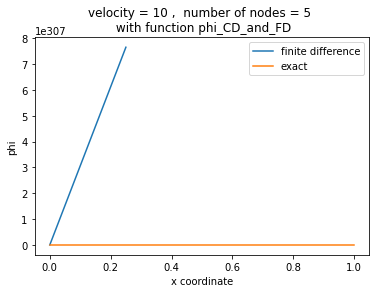

error


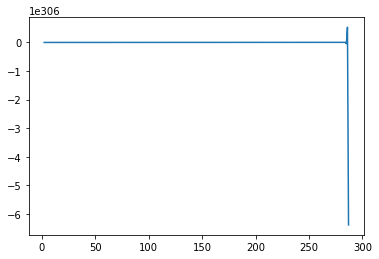

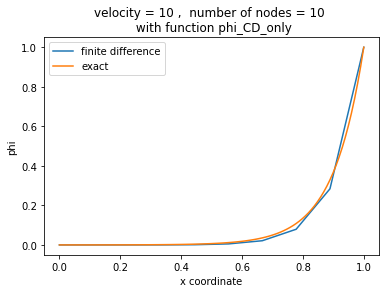

error


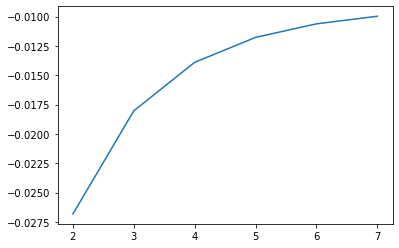

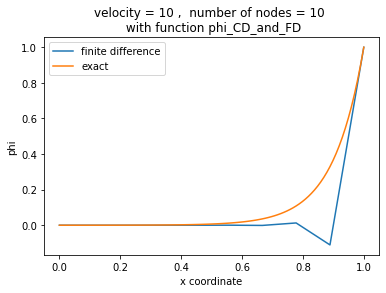

error


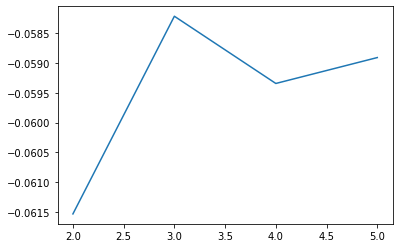

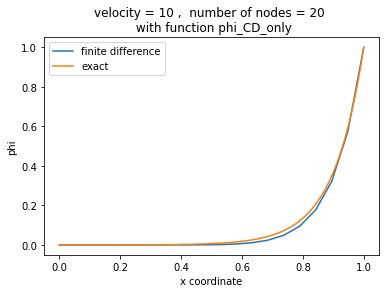

error


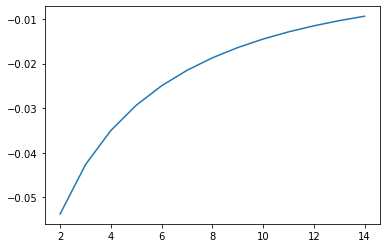

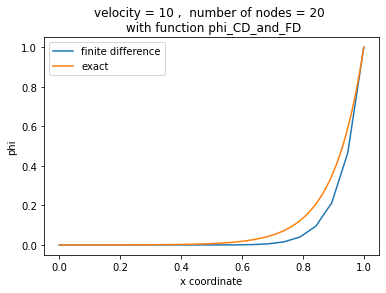

error


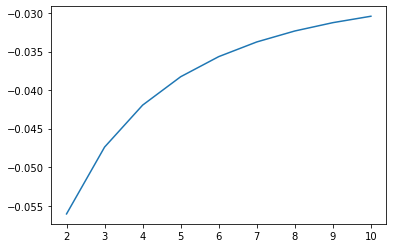

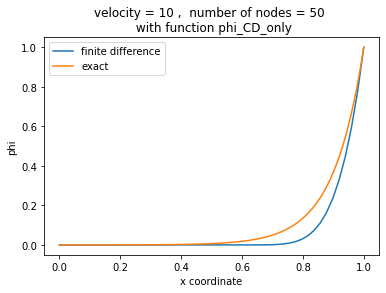

error


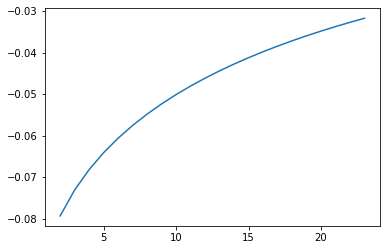

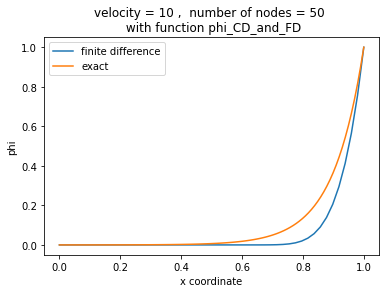

error


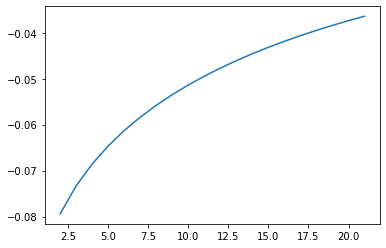

In [192]:
## Create a for loop to create all necessary graphs
a = [1,10]
## start with the convective velocities
for velocity in a:
    
    

    ## then the number of nodes for finite difference
    for n_nodes in [3,5,10,20,50]:
        ##create the exact solutions
        x_exact = np.linspace(0,1,n_nodes)
        Pe = Peclet(velocity, L, k)
        phi_ex = phi_exact(x_exact, Pe, L)
        
        ##then for each of the schemes
        for scheme in [phi_CD_only, phi_CD_and_FD]:
            
            ## create the mesh
            mesh, indices = create_mesh(boundary_values = [phi_0, phi_1],
                               boundary_locations = [0,L], 
                               n_nodes = n_nodes, 
                               dimensions = [0, L])
            error_array = [np.inf, np.inf]
            ## apply the scheme iteratively 
            while np.abs(error_array[-1]-error_array[-2])>=0.001 or len(error_array)<5:
                array_iteration(scheme, mesh, indices, kappa = k, a = velocity)
                error_array.append((mesh[1]-phi_ex).mean())
                if len(error_array)>=1000:
                    print("failed to converge")
                    break
            
            ## create data for plotting exact solution
            x_exact_plot = np.linspace(0,1,n_nodes_exact)
            Pe_plot = Peclet(velocity, L, k)
            phi_ex_plot = phi_exact(x_exact_plot, Pe, L)
            
            plt.plot(mesh[0], mesh[1])
            plt.plot(x_exact_plot, phi_ex_plot)
            plt.legend(["finite difference", "exact"])
            plt.title(f"velocity = {velocity} ,  number of nodes = {n_nodes} \n with function {scheme.__name__}")
            plt.ylabel('phi')
            plt.xlabel('x coordinate')
            plt.pause(0.001)
            
            print("error")
            plt.plot(error_array)
            plt.pause(0.001)
    

In [99]:
n_nodes = 5
mesh, indices = create_mesh(boundary_values = [0,1], boundary_locations = [0,1], n_nodes = n_nodes, dimensions = [0,1])

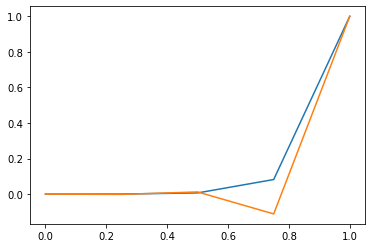

In [111]:
x_exact = np.linspace(0,1,n_nodes)
Pe = Peclet(a[1], L, k)
phi_exct = phi_exact(x_exact, Pe, L)
#plt.plot(x_exact, phi_exct)

array_iteration(phi_CD_only, mesh, indices, kappa=k, a=a[1]) 
#print(mesh)
#plt.plot(mesh[0],mesh[1])
plt.plot(mesh[0],phi_exct)
plt.plot(mesh[0],mesh[1])
#plt.plot(mesh[0],mesh[1]-phi_exct)

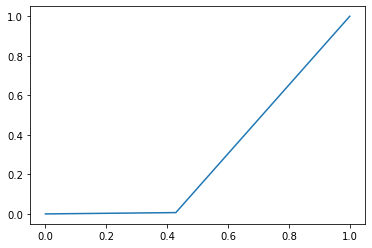

In [228]:
    x_exact = np.linspace(0,1,n_nodes)
    Pe = Peclet(a[1], L, k)
    phi_exct = phi_exact(x_exact, Pe, L)
    #plt.plot(x_exact, phi_exct)


    array_iteration(phi_CD_and_FD, mesh, indices) 
    #print(mesh)
    #plt.plot(mesh[0],mesh[1])
    #plt.plot(mesh[0],phi_exct)
    plt.plot(mesh[1],phi_exct)
    #plt.plot(mesh[0],mesh[1]-phi_exct)

In [191]:
n_nodes = 5
mesh, indices = create_mesh(boundary_values = [0,1], boundary_locations = [0,1], n_nodes = n_nodes, dimensions = [0,1])

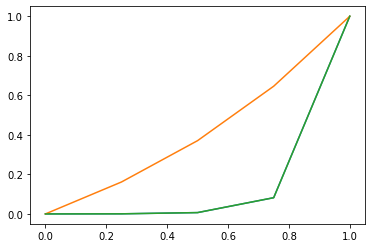

In [201]:
    x_exact = np.linspace(0,1,n_nodes)
    Pe = Peclet(a[1], L, k)
    phi_exct = phi_exact(x_exact, Pe, L)
    plt.plot(x_exact, phi_exct)


    array_iteration(phi_CD_only, mesh, indices) 
    #print(mesh)
    plt.plot(mesh[0],mesh[1])
    plt.plot(mesh[0],phi_exct)
    #plt.plot(mesh[0],mesh[1]-phi_exct)

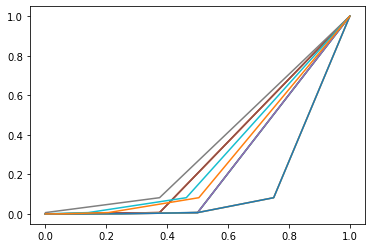

In [140]:
error_array = []
for n_nodes in [3,5]:
    mesh, indices = create_mesh(boundary_values = [0,1], boundary_locations = [0,1], n_nodes = n_nodes, dimensions = [0,1])
    for i in range(0,3):
        x_exact = np.linspace(0,1,n_nodes)
        Pe = Peclet(a[1], L, k)
        phi_exct = phi_exact(x_exact, Pe, L)
        plt.plot(x_exact, phi_exct)


        array_iteration(phi_CD_only, mesh, indices) 
        #print(mesh)
        #plt.plot(mesh[0],mesh[1])
        plt.plot(mesh[1],phi_exct)
        #plt.plot(mesh[0],mesh[1]-phi_exct)

        max_error = np.max(np.abs(mesh[1]-phi_exct))
    error_array.append(max_error)

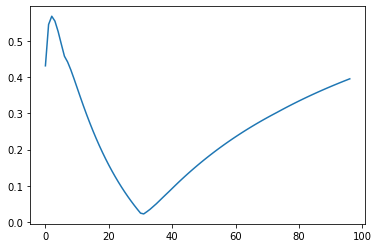

In [1504]:
plt.plot(error_array)